In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import numpy as np
from keras.models import Model
from keras.optimizers import Adam

In [ ]:
# Загрузка датасета
data = od.download(
    "https://www.kaggle.com/datasets/andrewmvd/doom-crossing/data")

Skipping, found downloaded files in "./doom-crossing" (use force=True to force download)


In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Shape: {IMG_SHAPE}")

doom_color = '#B9121B'
ac_color = '#3CAEA3'

initial_epochs = 10

Batch Size: 32
Image Shape: (64, 64, 3)


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/doom-crossing', image_size=(64, 64), label_mode='int')

data = data.map(lambda x,y: (x/255, y))

Found 1597 files belonging to 2 classes.


In [ ]:
train_size_percentage = 0.7
val_size_percentage = 0.2
test_size_percentage = 0.1

spared_batches = len(data) % 10

train_size = int(len(data) * train_size_percentage)
val_size = int(len(data) * val_size_percentage)
test_size = int(len(data) * test_size_percentage) + spared_batches

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
for images, labels in train.take(1):
    print("Форма изображений:", images.shape)
    print("Тип изображений:", images.dtype)
    print("Форма меток:", labels.shape)
    print("Тип меток:", labels.dtype)

Форма изображений: (32, 64, 64, 3)
Тип изображений: <dtype: 'float32'>
Форма меток: (32,)
Тип меток: <dtype: 'int32'>


In [ ]:
def train_model(model, train, val, initial_epochs, callbacks):
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
      loss='binary_crossentropy',
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
      ]
    )

    hist = model.fit(train,
                     epochs=initial_epochs,
                     validation_data=val,
                     callbacks=[tensorboard_callback])

    # График функции потерь
    fig = plt.figure()
    plt.plot(hist.history['loss'], color=doom_color, label='loss')
    plt.plot(hist.history['val_loss'], color=ac_color, label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    # График точности
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color=doom_color, label='accuracy')
    plt.plot(hist.history['val_accuracy'], color=ac_color, label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

In [ ]:
def test_model(model, test):
    y_true = []
    y_pred = []

    precision = Precision()
    recall = Recall()
    binary_accuracy = BinaryAccuracy()

    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)

        y_true.extend(y)
        y_pred.extend((yhat > 0.5).astype(int))

        precision.update_state(y, yhat)
        recall.update_state(y, yhat)
        binary_accuracy.update_state(y, yhat)

    print(f'Precision: {precision.result():.2f}, Recall: {recall.result():.2f}, Binary Accuracy: {binary_accuracy.result():.2f}')

    cm = confusion_matrix(y_true, y_pred)
    labels = test.class_names if hasattr(test, 'class_names') else ['class_0', 'class_1']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Простая сверточная нейронная сеть

In [ ]:
model1 = Sequential([
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=IMG_SHAPE),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

In [ ]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7634 - loss: 0.4987 - precision: 0.7951 - recall: 0.7525 - val_accuracy: 0.7344 - val_loss: 0.5221 - val_precision: 0.7303 - val_recall: 0.7784
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.7578 - loss: 0.4968 - precision: 0.7820 - recall: 0.7801 - val_accuracy: 0.7437 - val_loss: 0.5244 - val_precision: 0.8176 - val_recall: 0.6875
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.7859 - loss: 0.4725 - precision: 0.8318 - recall: 0.7380 - val_accuracy: 0.7625 - val_loss: 0.5195 - val_precision: 0.7200 - val_recall: 0.8780
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7576 - loss: 0.5073 - precision: 0.7709 - recall: 0.7851 - val_accuracy: 0.7344 - val_loss: 0.5390 - val_precision: 0.8571 - val_recall: 0.6171
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7687 - loss: 0.4896 - precision: 0.8145 - recall: 0.7482 - val_accuracy: 0.7656 - val_loss: 0.5117 - val

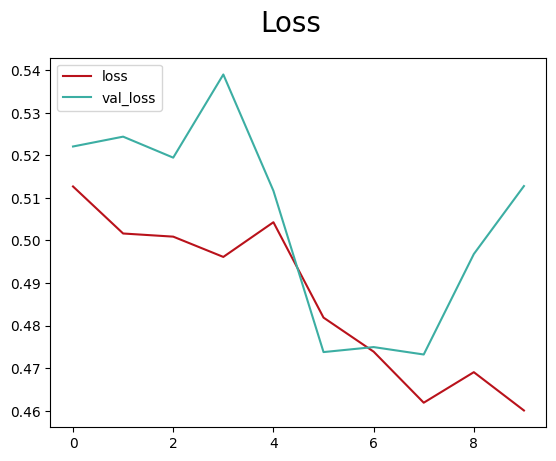

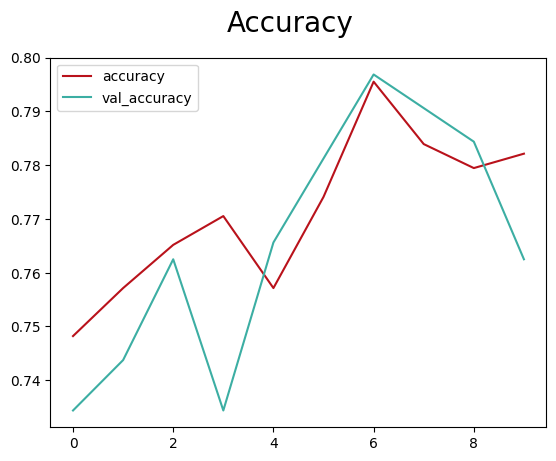

In [ ]:
train_model(model1, train, val, initial_epochs, tensorboard_callback)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Precision: 0.74, Recall: 0.89, Binary Accuracy: 0.81


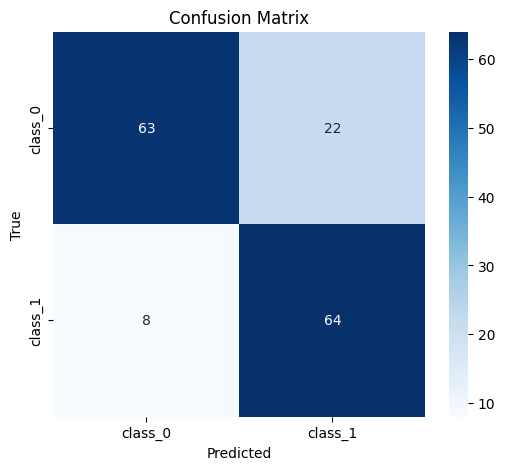

In [ ]:
test_model(model, test)

Сверточная нейронная сеть с применением BatchNorm

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=IMG_SHAPE),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), 1, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128,(3,3), 1, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.6268 - loss: 0.9147 - precision: 0.6247 - recall: 0.7515 - val_accuracy: 0.4969 - val_loss: 0.6990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.7171 - loss: 0.6625 - precision: 0.7431 - recall: 0.7248 - val_accuracy: 0.4750 - val_loss: 0.7035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7134 - loss: 0.6577 - precision: 0.7693 - recall: 0.7041 - val_accuracy: 0.5156 - val_loss: 0.7008 - val_precision: 1.0000 - val_recall: 0.0064
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7811 - loss: 0.4942 - precision: 0.8050 - recall: 0.7833 - val_accuracy: 0.5063 - val_loss: 0.7101 - val_precision: 0.9000 - val_recall: 0.0542
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7889 - loss: 0.4440 - precision: 0.8246 - recall: 0.7753 - val_accuracy: 0.4906 - val_lo

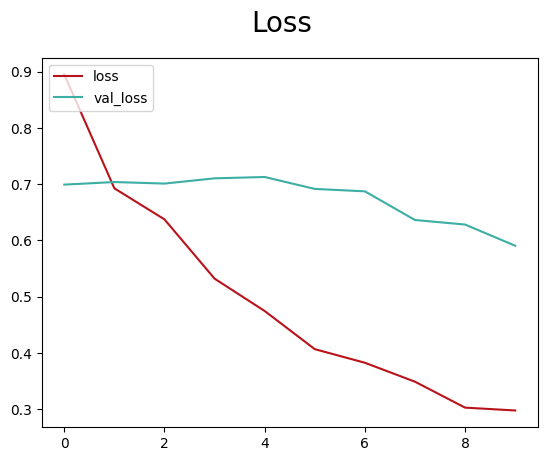

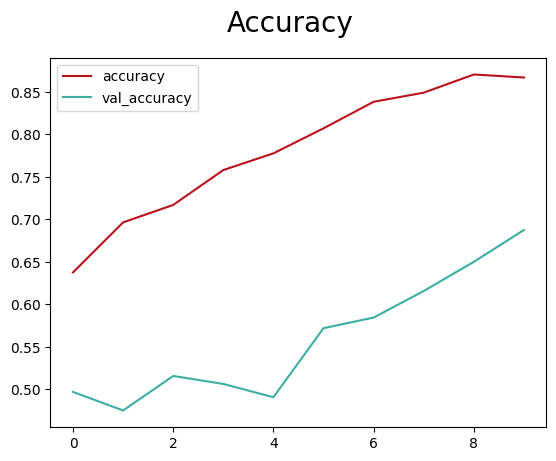

In [ ]:
train_model(model2, train, val, initial_epochs, tensorboard_callback)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
[[0.78283554]
 [0.5664281 ]
 [0.41286644]
 [0.418447  ]
 [0.3143316 ]
 [0.03112288]
 [0.21428324]
 [0.8764469 ]
 [0.3913295 ]
 [0.132654  ]
 [0.52587473]
 [0.3448164 ]
 [0.28837693]
 [0.10554609]
 [0.571557  ]
 [0.02636075]
 [0.5041667 ]
 [0.02937388]
 [0.00839557]
 [0.74166316]
 [0.8212248 ]
 [0.2573269 ]
 [0.21366374]
 [0.5417414 ]
 [0.14098832]
 [0.0416499 ]
 [0.8646592 ]
 [0.42622164]
 [0.80800617]
 [0.16731662]
 [0.5556025 ]
 [0.09922075]] before
[array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0])] after
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
[[0.0899842 ]
 [0.5118622 ]
 [0.42435935]
 [0.18991078]
 [0.7905777 ]
 [0.2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
[[0.17508252]
 [0.29867923]
 [0.84249824]
 [0.6206943 ]
 [0.89471084]
 [0.9233409 ]
 [0.3057582 ]
 [0.7575357 ]
 [0.21088699]
 [0.23893474]
 [0.4841234 ]
 [0.6720164 ]
 [0.3309461 ]
 [0.13952269]
 [0.26255128]
 [0.04504452]
 [0.12878886]
 [0.44899714]
 [0.557297  ]
 [0.83315665]
 [0.05071584]
 [0.13950707]
 [0.50606614]
 [0.15699238]
 [0.6038392 ]
 [0.5463984 ]
 [0.03752371]
 [0.10500462]
 [0.47633237]] before
[array([1]), array([1]), array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([0]), array([1]), array(

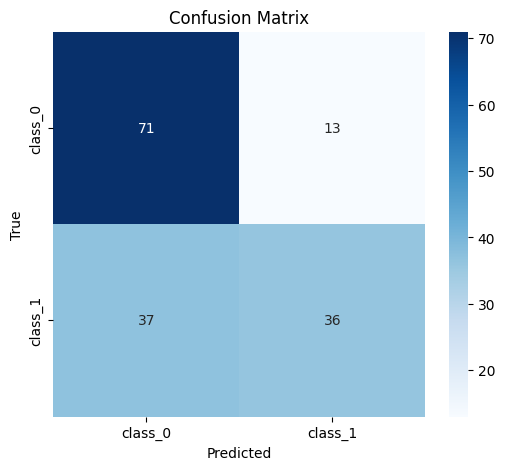

In [ ]:
test_model(model2, test)

Архитектура вдохновленная сетью alexnet

In [ ]:
alexnet = Sequential([
     tf.keras.layers.Conv2D(64, 11, strides=(4,4), activation='relu', input_shape=IMG_SHAPE),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
     tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
     tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(4096, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(4096, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Сохраняем данные об обучении
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.5289 - loss: 0.6850 - precision: 0.5413 - recall: 0.9290 - val_accuracy: 0.7188 - val_loss: 0.5760 - val_precision: 0.7615 - val_recall: 0.6266
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.7000 - loss: 0.5943 - precision: 0.7736 - recall: 0.6435 - val_accuracy: 0.7000 - val_loss: 0.5868 - val_precision: 0.8047 - val_recall: 0.5920
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.7496 - loss: 0.5485 - precision: 0.7814 - recall: 0.7460 - val_accuracy: 0.7344 - val_loss: 0.5521 - val_precision: 0.7984 - val_recall: 0.6358
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7549 - loss: 0.5258 - precision: 0.7856 - recall: 0.7549 - val_accuracy: 0.6750 - val_loss: 0.6024 - val_precision: 0.8586 - val_recall: 0.4857
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.7707 - loss: 0.5234 - precision: 0.7891 - recall: 0.7878 - val_accuracy: 0.7437 - val_loss: 0.5311 - val

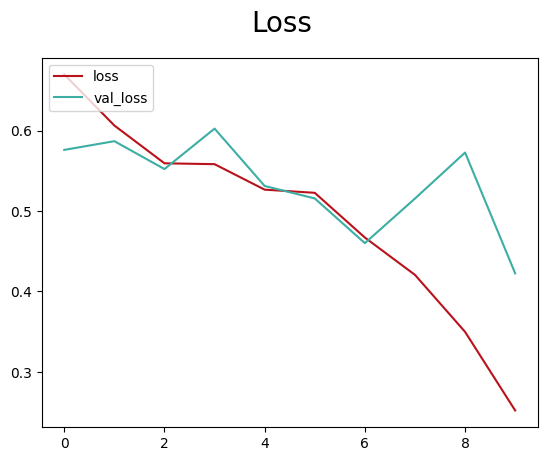

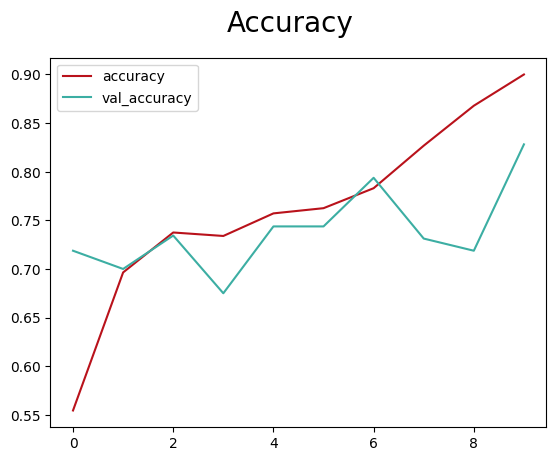

In [ ]:
train_model(alexnet, train, val, initial_epochs, tensorboard_callback)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
[[0.04366463]
 [0.06414681]
 [0.9360229 ]
 [0.9941175 ]
 [0.41618374]
 [0.26211405]
 [0.7924937 ]
 [0.98199725]
 [0.05206277]
 [0.07688731]
 [0.78082055]
 [0.02813013]
 [0.87018746]
 [0.29017362]
 [0.86444116]
 [0.05069599]
 [0.9974879 ]
 [0.07566354]
 [0.09288862]
 [0.8294015 ]
 [0.98728704]
 [0.0435062 ]
 [0.9837387 ]
 [0.21279192]
 [0.93714845]
 [0.3724547 ]
 [0.41231838]
 [0.462192  ]
 [0.33321577]
 [0.98544496]
 [0.2536287 ]
 [0.9999871 ]] before
[array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([1]), array([1]), array([0]), array([1]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([1]), array([0]), array([1])] after
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
[[0.06156582]
 [0.07172205]
 [0.12079389]
 [0.7560115 ]
 [0.9702001 ]
 [0.8

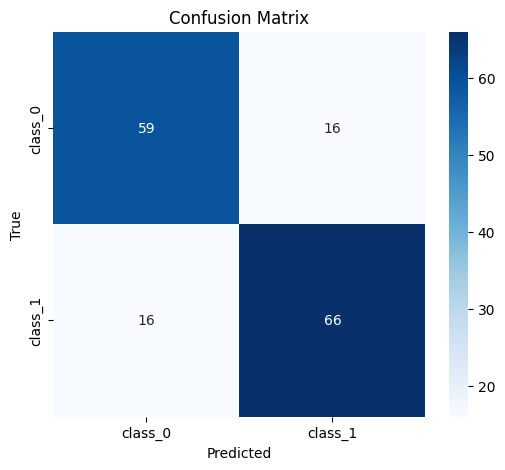

In [ ]:
test_model(alexnet, test)

In [ ]:
plot_model(model1, to_file='model1.png', show_shapes=True, show_layer_names=True)
Image(filename='model1.png')

In [ ]:
plot_model(model2, to_file='model3.png', show_shapes=True, show_layer_names=True)
Image(filename='model2.png')

In [ ]:
plot_model(model3, to_file='model3.png', show_shapes=True, show_layer_names=True)
Image(filename='model3.png')

In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 473,045 (1.80 MB)

 Trainable params: 157,681 (615.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 315,364 (1.20 MB)

In [ ]:
model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 62, 62, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 688,997 (2.63 MB)

 Trainable params: 229,505 (896.50 KB)

 Non-trainable params: 480 (1.88 KB)

 Optimizer params: 459,012 (1.75 MB)

In [ ]:
alexnet.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 14, 14, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 7, 7, 256)      │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 3, 3, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 3, 3, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 3, 3, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,106,501 (244.55 MB)

 Trainable params: 21,368,833 (81.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,737,668 (163.03 MB)